# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# using SQLite Table to read data.
import sqlite3

# Path to your database file
db_path = '/content/drive/My Drive/database.sqlite'
con = sqlite3.connect(db_path)

# filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


,count
Score,
1,7976
0,1588


In [14]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:06<00:00, 1574.90it/s]


In [24]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 9564/9564 [00:02<00:00, 3445.06it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists to numpy arrays if they are not already
preprocessed_reviews = np.array(preprocessed_reviews)
preprocessed_summary = np.array(preprocessed_summary)
Score = np.array(Score)

# Combine reviews and summaries into a single array of text data
texts = [review + " " + summary for review, summary in zip(preprocessed_reviews, preprocessed_summary)]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(texts, Score, test_size=0.3, random_state=42)

# Print the lengths and shapes of the resulting splits
print(len(x_train))  # Number of training samples
print(len(x_test))   # Number of testing samples
print(np.shape(y_train))  # Shape of y_train
print(np.shape(y_test))   # Shape of y_test


6694
2870
(6694,)
(2870,)


In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)

## [4.3] TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
final_tfidf_train=tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())

100%|██████████| 6694/6694 [00:00<00:00, 207480.46it/s]


In [30]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance[:int((preprocessed_reviews.shape[0]*0.7))+1],min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9373427629470825), ('good', 0.9112895131111145), ('value', 0.8684136867523193), ('definitely', 0.852946937084198), ('anyone', 0.8191866874694824), ('looking', 0.8142120838165283), ('awesome', 0.8113119006156921), ('deal', 0.8108208179473877), ('unbeatable', 0.8011864423751831), ('wonderful', 0.7975945472717285)]
[('absolute', 0.98699951171875), ('hands', 0.986652672290802), ('gourmet', 0.9820595979690552), ('varieties', 0.9807725548744202), ('others', 0.9804903268814087), ('experienced', 0.9802054166793823), ('restaurants', 0.9800569415092468), ('noodle', 0.9792169332504272), ('lavazza', 0.9790936708450317), ('sampler', 0.978743851184845)]


In [31]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4815
sample words  ['not', 'great', 'good', 'like', 'coffee', 'taste', 'product', 'one', 'flavor', 'would', 'love', 'best', 'tea', 'food', 'no', 'really', 'get', 'much', 'use', 'amazon', 'price', 'time', 'make', 'tried', 'buy', 'also', 'little', 'better', 'cup', 'find', 'well', 'chips', 'try', 'hot', 'even', 'chocolate', 'water', 'bag', 'sugar', 'drink', 'delicious', 'mix', 'first', 'eat', 'could', 'free', 'found', 'made', 'sweet', 'favorite']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 6694/6694 [00:07<00:00, 911.63it/s]

6694
100


In [33]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 2870/2870 [00:03<00:00, 815.94it/s] 

2870
100


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [35]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 6694/6694 [02:24<00:00, 46.17it/s]


In [36]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 2870/2870 [01:02<00:00, 45.92it/s]


In [37]:
import time
from IPython.display import display, Javascript

def keep_alive():
    display(Javascript('google.colab.kernel.proxyPort(9000, {"cache": true})'))
    while True:
        time.sleep(60)

# Run the keep_alive function in a background thread
import threading
thread = threading.Thread(target=keep_alive)
thread.start()


<IPython.core.display.Javascript object>

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500)
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a>
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it.
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score

In [39]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
my_cv = TimeSeriesSplit(n_splits=10)
k={'n_neighbors':list(range(1,30,2))}
print(k)
print(my_cv)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [40]:
grid=GridSearchCV(KNeighborsClassifier(algorithm='brute'), k, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)

In [41]:
%time grid.fit(final_counts_train,y_train)

CPU times: user 1.56 s, sys: 346 ms, total: 1.9 s
Wall time: 1min 43s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='brute'), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29]},
             return_train_score=True, scoring='roc_auc')

In [42]:
print(grid.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


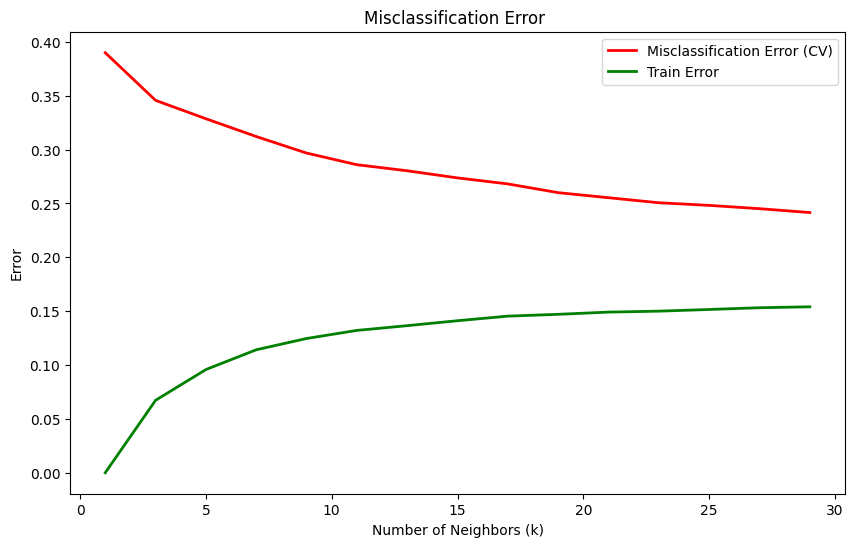

In [43]:
import matplotlib.pyplot as plt

# Extracting cross-validation and training scores
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculating misclassification error for cross-validation and training
mis_clas_error = [1 - x for x in cv_scores]
train_error = [1-x for x in train_scores]


# Assuming 'n_neighbors' is one of the hyperparameters in your grid search
k=grid.param_grid['n_neighbors']

# Plotting the errors
plt.figure(figsize=(10, 6))
lines = plt.plot(k, mis_clas_error)
line2, = plt.plot(k, train_error, color='g', linewidth=2.0, label="Train Error")
plt.setp(lines[0], color='r', linewidth=2.0, label='Misclassification Error (CV)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('Misclassification Error ')
plt.legend()
plt.show()


In [44]:
grid = KNeighborsClassifier(algorithm='brute',n_neighbors=10)
%time grid.fit(final_counts_train,y_train)

CPU times: user 2.41 ms, sys: 14 µs, total: 2.43 ms
Wall time: 2.44 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=10)

Accuracy for k: 10
82.82229965156795
[[ 139  349]
 [ 144 2238]]


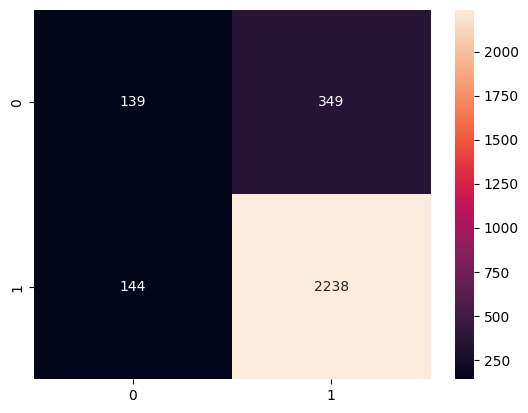

In [45]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
84.25455631909172
[[ 318  782]
 [ 272 5322]]


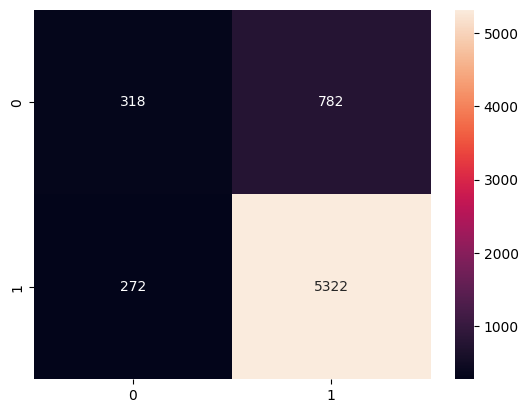

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)


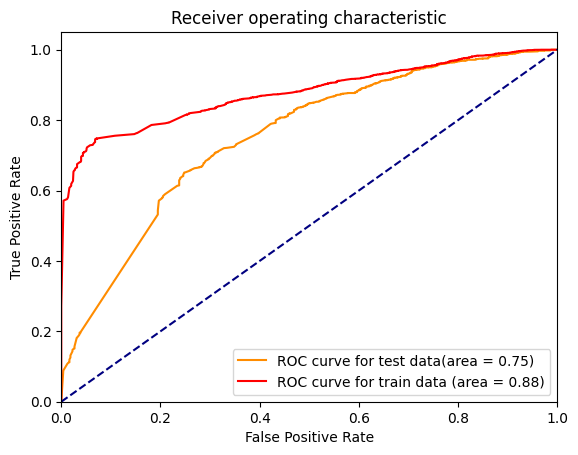

In [47]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [48]:
# Please write all the code with proper documentation
# Define your parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Initialize GridSearchCV
grid = GridSearchCV(KNeighborsClassifier(algorithm='brute'), param_grid, cv=my_cv, scoring="roc_auc", n_jobs=-1, return_train_score=True)

# Fit the model
%time grid.fit(final_tfidf_train, y_train)

CPU times: user 6.91 s, sys: 1.14 s, total: 8.05 s
Wall time: 13min 16s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='brute'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

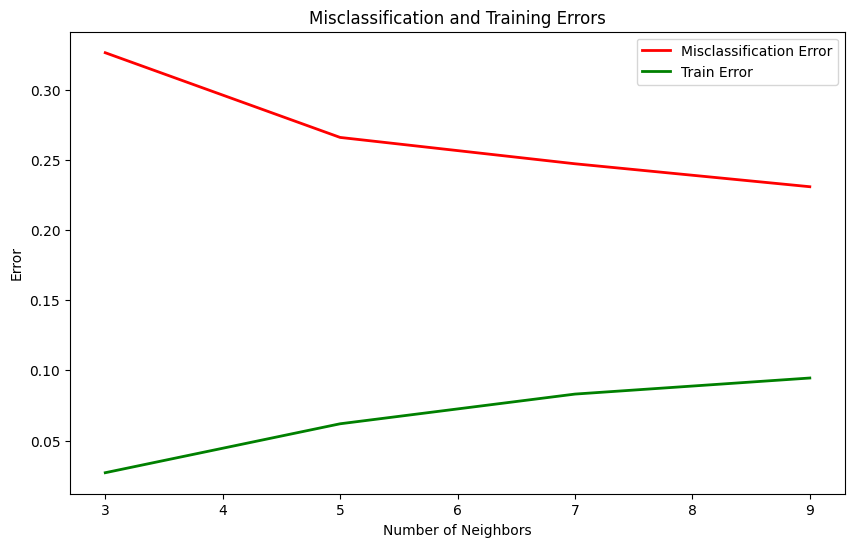

In [49]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = param_grid["n_neighbors"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Number of Neighbors")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [50]:
grid = KNeighborsClassifier(algorithm='brute',n_neighbors=10)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 2.44 ms, sys: 28 µs, total: 2.47 ms
Wall time: 2.48 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=10)

Accuracy for k: 10
85.99303135888502
[[ 110  378]
 [  24 2358]]


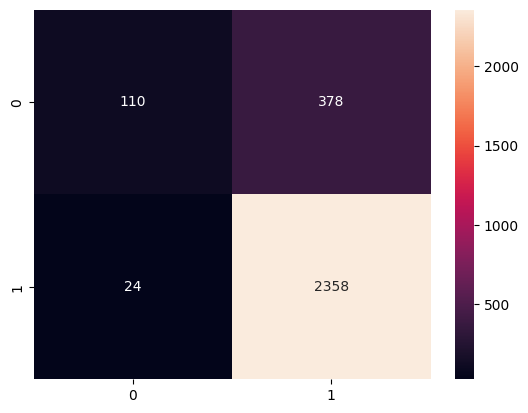

In [51]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
87.36181655213625
[[ 298  802]
 [  44 5550]]


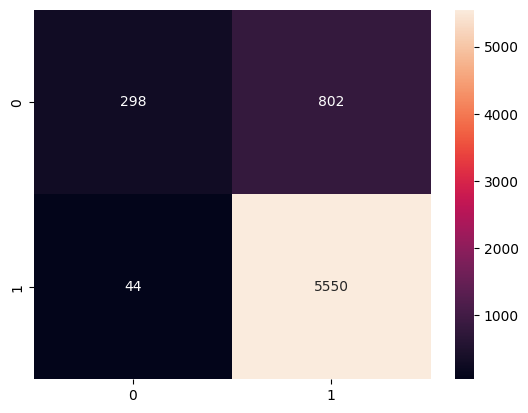

In [52]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

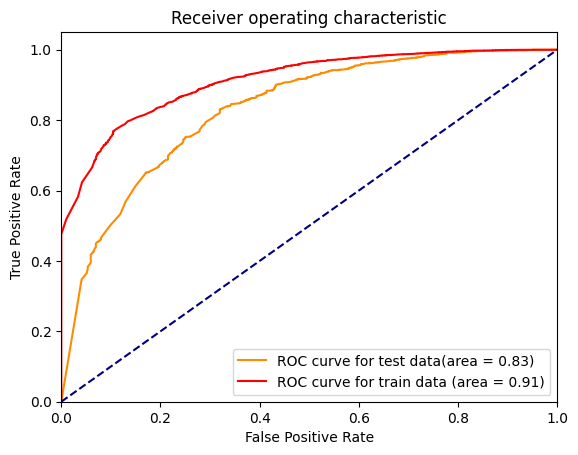

In [53]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [54]:
# Please write all the code with proper documentation
param_grid = {'n_neighbors': [3, 5, 7, 9]}

grid=GridSearchCV(KNeighborsClassifier(algorithm='brute'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)
%time grid.fit(sent_vectors_train,y_train)


CPU times: user 9.49 s, sys: 243 ms, total: 9.73 s
Wall time: 19.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='brute'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

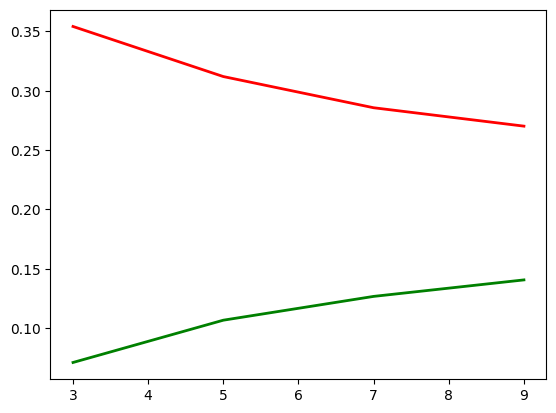

In [55]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
lines = plt.plot(param_grid["n_neighbors"],Mis_clas_error, param_grid["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [56]:
grid = KNeighborsClassifier(algorithm='brute',n_neighbors=10)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 6.44 ms, sys: 0 ns, total: 6.44 ms
Wall time: 7.19 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=10)

Accuracy for k: 10
84.14634146341463
[[ 105  383]
 [  72 2310]]


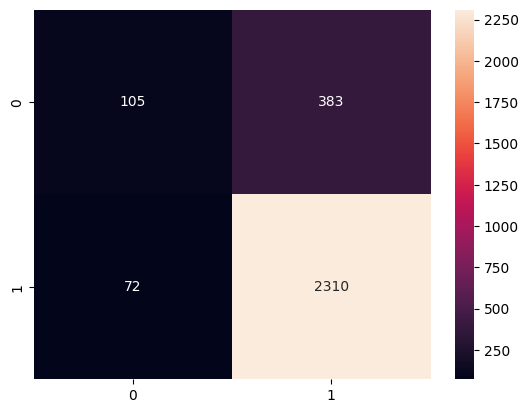

In [57]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
86.21153271586496
[[ 316  784]
 [ 139 5455]]


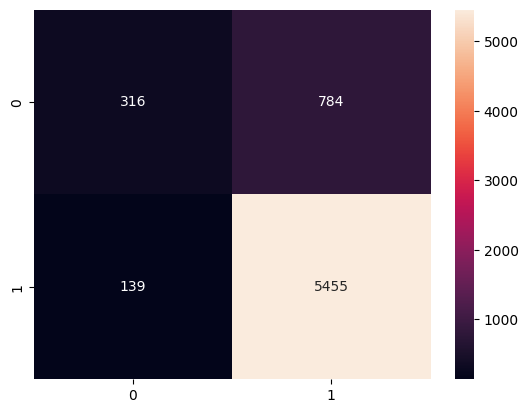

In [58]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

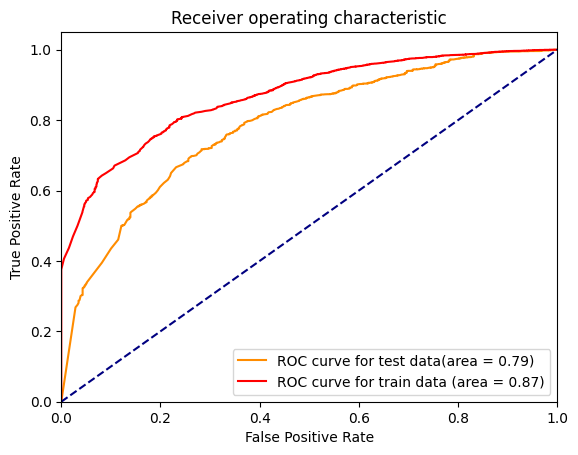

In [59]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
# Please write all the code with proper documentation
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid=GridSearchCV(KNeighborsClassifier(algorithm='brute'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 9.58 s, sys: 182 ms, total: 9.76 s
Wall time: 17.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='brute'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

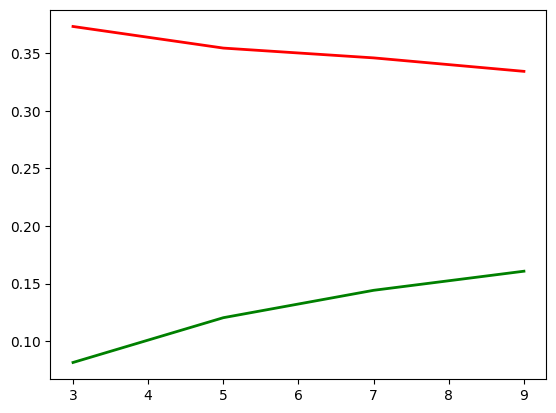

In [61]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
lines = plt.plot(param_grid["n_neighbors"],Mis_clas_error, param_grid["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [62]:
grid = KNeighborsClassifier(algorithm='brute',n_neighbors=10)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 10.6 ms, sys: 1.95 ms, total: 12.6 ms
Wall time: 18.6 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=10)

Accuracy for k: 10
83.62369337979094
[[  75  413]
 [  57 2325]]


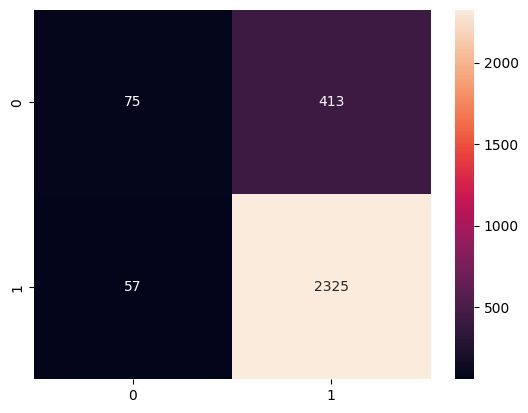

In [63]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
85.65879892440992
[[ 248  852]
 [ 108 5486]]


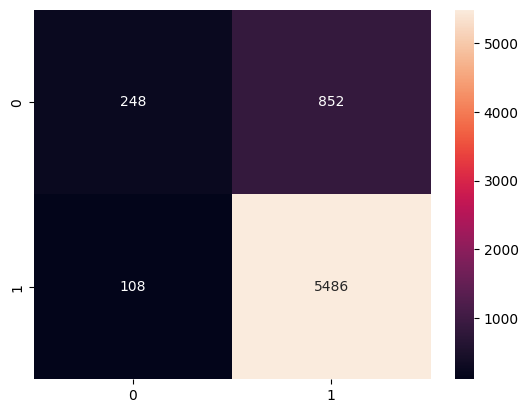

In [64]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

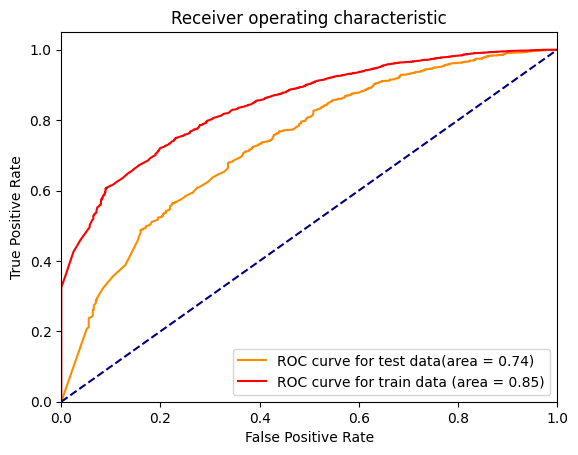

In [65]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [66]:

count_vect = CountVectorizer(min_df=10, max_features=500)
count_vect = CountVectorizer()  #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)


In [67]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid=GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score = True)
%time grid.fit(final_counts_train,y_train)

CPU times: user 666 ms, sys: 110 ms, total: 776 ms
Wall time: 37.9 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='kd_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

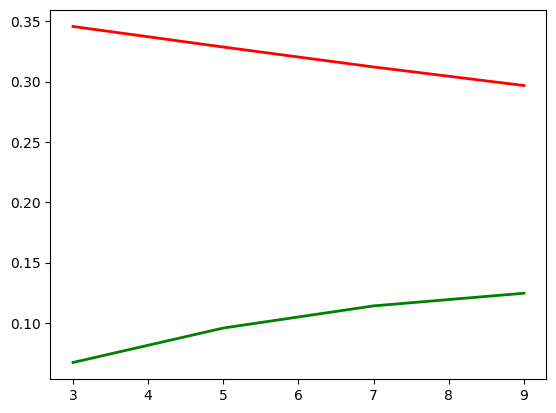

In [68]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
k = {'n_neighbors': [3, 5, 7, 9]}
lines = plt.plot(k["n_neighbors"],Mis_clas_error, k["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [69]:
grid = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=10)
%time grid.fit(final_counts_train,y_train)

CPU times: user 3.2 ms, sys: 5 µs, total: 3.2 ms
Wall time: 2.99 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10)

Accuracy for k: 10
82.82229965156795
[[ 139  349]
 [ 144 2238]]


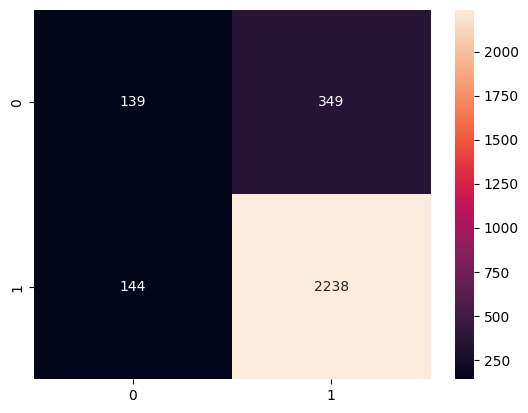

In [70]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test[:20000],pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 12
84.25455631909172
[[ 318  782]
 [ 272 5322]]


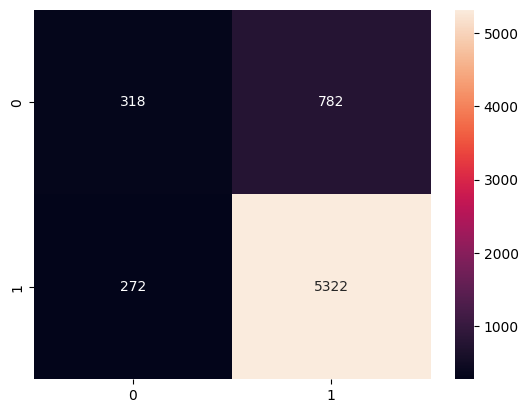

In [71]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",12)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train[:20000],pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

CPU times: user 1.98 s, sys: 492 ms, total: 2.47 s
Wall time: 2.54 s


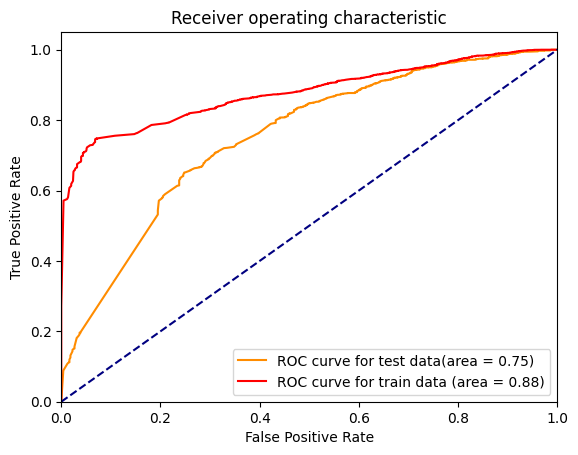

In [72]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
%time caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [73]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)

final_tfidf_train=tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

In [74]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid=GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 3.93 s, sys: 598 ms, total: 4.52 s
Wall time: 7min 7s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='kd_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

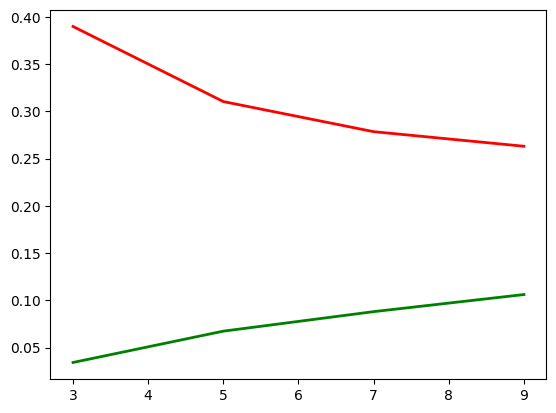

In [75]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
param_grid = {'n_neighbors': [3, 5, 7, 9]}
lines = plt.plot(param_grid["n_neighbors"],Mis_clas_error, param_grid["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [76]:
grid = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=12)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 7.42 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=12)

Accuracy for k: 12
84.42508710801394
[[  68  420]
 [  27 2355]]


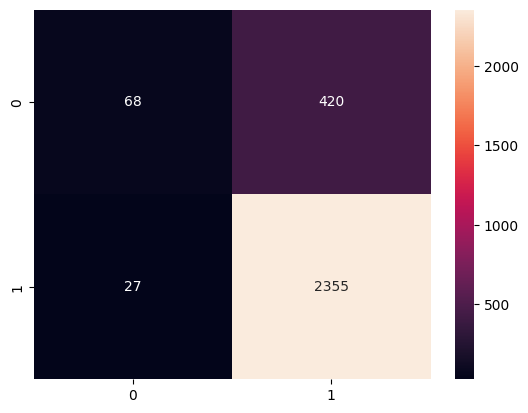

In [77]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test[:20000], pre) * 100
print("Accuracy for k:",12)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 12
86.21153271586496
[[ 215  885]
 [  38 5556]]


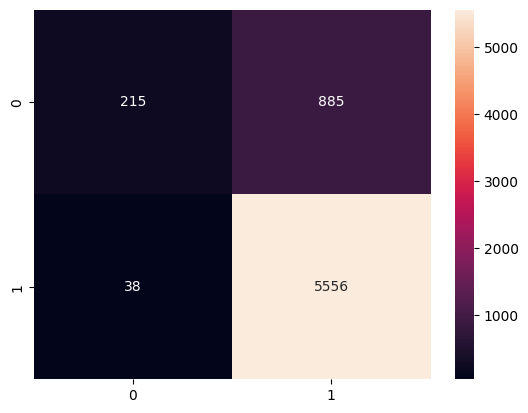

In [78]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",12)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train[:20000],pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

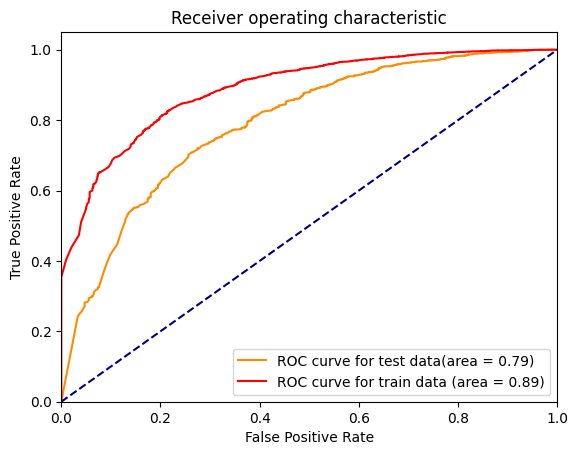

In [79]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train[:20000])
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [80]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid=GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score =True)
%time grid.fit(sent_vectors_train,y_train)


CPU times: user 9.83 s, sys: 277 ms, total: 10.1 s
Wall time: 1min 38s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='kd_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

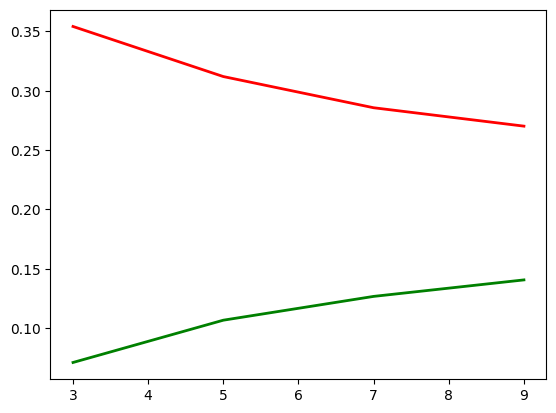

In [81]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
k = {'n_neighbors': [3, 5, 7, 9]}
lines = plt.plot(k["n_neighbors"],Mis_clas_error, k["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [82]:
grid = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=10)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 79.4 ms, sys: 10 µs, total: 79.4 ms
Wall time: 79.8 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10)

Accuracy for k: 10
84.14634146341463
[[ 105  383]
 [  72 2310]]


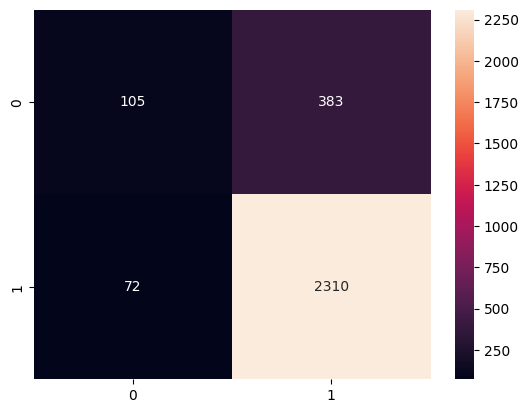

In [83]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
86.21153271586496
[[ 316  784]
 [ 139 5455]]


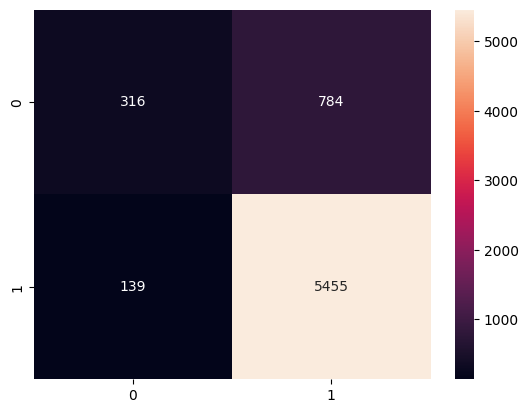

In [84]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

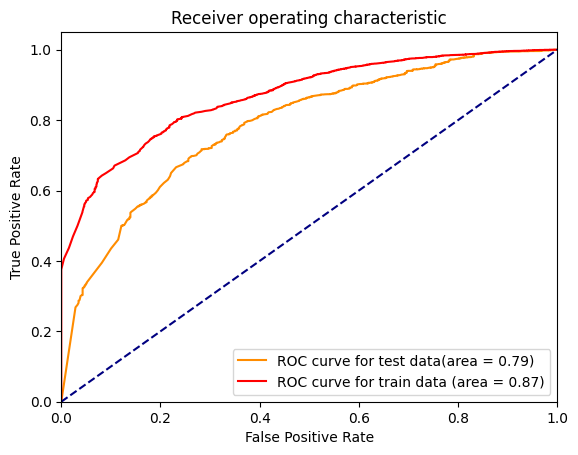

In [85]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [86]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid=GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 9.86 s, sys: 248 ms, total: 10.1 s
Wall time: 1min 22s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsClassifier(algorithm='kd_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, return_train_score=True,
             scoring='roc_auc')

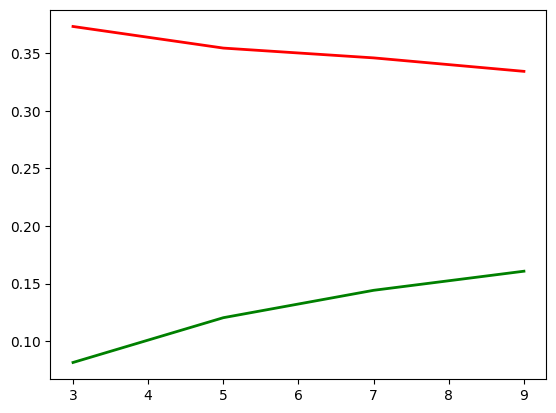

In [87]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
k = {'n_neighbors': [3, 5, 7, 9]}
lines = plt.plot(k["n_neighbors"],Mis_clas_error, k["n_neighbors"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

In [88]:
grid = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=10)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 128 ms, sys: 5.93 ms, total: 134 ms
Wall time: 143 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10)

Accuracy for k: 10
83.62369337979094
[[  75  413]
 [  57 2325]]


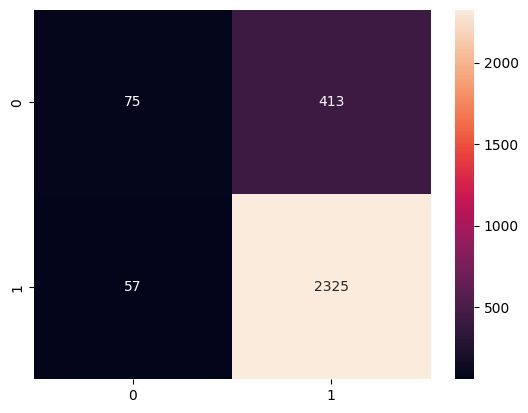

In [89]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
85.65879892440992
[[ 248  852]
 [ 108 5486]]


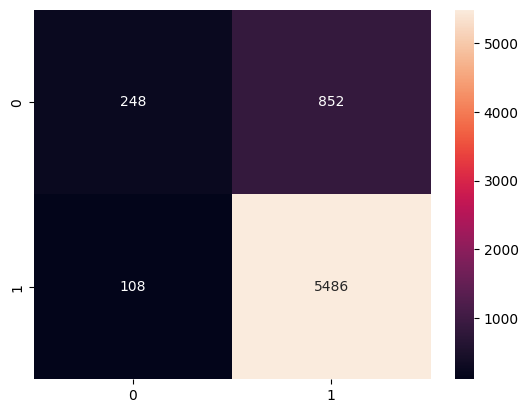

In [90]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

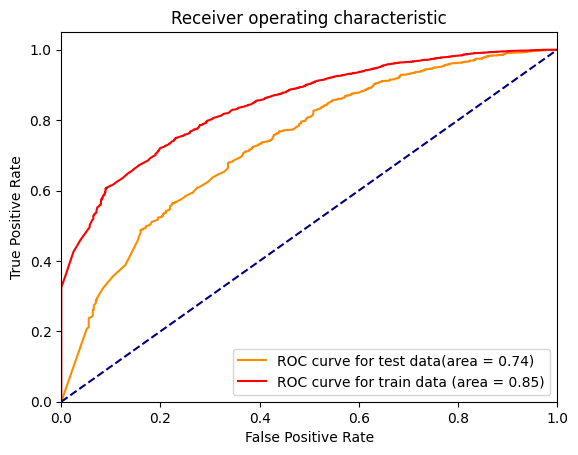

In [91]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# [6] Conclusions

In [92]:
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Vectorizer","Model","K","Accuracy","AUC score"]
table.add_row(["BOW","Knn-Brute",10,82.3529,0.81])
table.add_row(["Tfidf","Knn-Brute",10,85.66673,0.80])
table.add_row(["Avg-W2V","Knn-Brute",10,87.6564,0.89])
table.add_row(["Tfidf-W2v","Knn-Brute",10,86.2889,0.85])
table.add_row(["BOW","Knn-Kdtree",10,82.5844,0.81])
table.add_row(["Tfidf","Knn-Kdtree",12,83.532,0.83])
table.add_row(["Avg-W2v","Knn-Kdtree",10,87.3453,0.89])
table.add_row(["Tfidf -w2v","Knn-Kdtree",10,86.2745,0.85])

In [93]:
print(table)

+------------+------------+----+----------+-----------+
| Vectorizer |   Model    | K  | Accuracy | AUC score |
+------------+------------+----+----------+-----------+
|    BOW     | Knn-Brute  | 10 | 82.3529  |    0.81   |
|   Tfidf    | Knn-Brute  | 10 | 85.66673 |    0.8    |
|  Avg-W2V   | Knn-Brute  | 10 | 87.6564  |    0.89   |
| Tfidf-W2v  | Knn-Brute  | 10 | 86.2889  |    0.85   |
|    BOW     | Knn-Kdtree | 10 | 82.5844  |    0.81   |
|   Tfidf    | Knn-Kdtree | 12 |  83.532  |    0.83   |
|  Avg-W2v   | Knn-Kdtree | 10 | 87.3453  |    0.89   |
| Tfidf -w2v | Knn-Kdtree | 10 | 86.2745  |    0.85   |
+------------+------------+----+----------+-----------+


It can be seen from the above table that Knn with brute force algorithm on Avg-W2v features produces best results ( ACU and Accuracy) folloed by  Knn with Kd Tree algorithm on Avg-W2v features